<a href="https://colab.research.google.com/github/sultankeles/Breast_Cancer_Diagnosis/blob/main/Breast_Cancer_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Upload Dataset**

## 1.1. Download and extract INbreast dataset

In [1]:
!pip install -q gdown

In [2]:
import zipfile
import gdown
import os

# Define file ID and output paths
file_id = "1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4"
zip_output = "INbreast_Release.zip"
extract_to = "/content/INbreast_Extracted"

# Download zip from Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_output, quiet = False)

# Extract the zip file
with zipfile.ZipFile(zip_output, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

Downloading...
From (original): https://drive.google.com/uc?id=1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4
From (redirected): https://drive.google.com/uc?id=1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4&confirm=t&uuid=802fc602-d9eb-4e3f-98a2-2699e3736218
To: /content/INbreast_Release.zip
100%|██████████| 2.01G/2.01G [01:06<00:00, 30.3MB/s]


In [3]:
dicom_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs"
jpg_output_dir = "/content/JPGs"

## 1.2 Convert DICOM to JPG

In [4]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.1 MB/s eta 0:00:00


In [5]:
import pydicom
import cv2
import numpy as np
import os
from tqdm import tqdm

dicom_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs"
jpg_output_dir = "/content/JPGs"
os.makedirs(jpg_output_dir, exist_ok = True)

def convert_dicom_to_jpg(dicom_path, jpg_path):
    dcm = pydicom.dcmread(dicom_path)
    img = dcm.pixel_array.astype(float)

    # Normalize to 0–255
    img = (np.maximum(img, 0) / img.max()) * 255.0
    img = np.uint8(img)

    # Save
    cv2.imwrite(jpg_path, img)


for filename in tqdm(os.listdir(dicom_dir)):
    if filename.endswith(".dcm"):
        file_id = filename.split("_")[0]
        dicom_path = os.path.join(dicom_dir, filename)
        jpg_path = os.path.join(jpg_output_dir, f"{file_id}.jpg")
        convert_dicom_to_jpg(dicom_path, jpg_path)

100%|██████████| 412/412 [00:50<00:00,  8.12it/s]


## 1.3 Convert ROI XML to JSON

In [6]:
import xml.etree.ElementTree as ET
import os
import json
import re

xml_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllXML"
output_json_path = "/content/annotations.json"
annotations = {}

def parse_point(point_str):
    # Remove parentheses and split into float x, y
    x, y = re.findall(r"[\d.]+", point_str)
    return {"x": int(float(x)), "y": int(float(y))}

for file in os.listdir(xml_dir):
    if not file.endswith(".xml"):
        continue

    xml_path = os.path.join(xml_dir, file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_id = file.replace(".xml", "") + ".jpg"
    rois = []

    # Navigate to ROIs
    for roi_group in root.iter("array"):
        for roi in roi_group.findall("dict"):
            name = None
            points = []
            keys = list(roi)
            for i in range(len(keys)):
                if keys[i].tag == "key" and keys[i].text == "Name":
                    name = keys[i+1].text
                if keys[i].tag == "key" and keys[i].text == "Point_px":
                    # Get all point strings inside the <array>
                    px_array = keys[i+1].findall("string")
                    for p in px_array:
                        points.append(parse_point(p.text))
            if name and points:
                rois.append({
                    "label": name,
                    "points": points
                })

    if rois:
        annotations[image_id] = rois

# Save to JSON
with open(output_json_path, "w") as f:
    json.dump(annotations, f, indent=4)

print(f"[INFO] ROI annotations parsed: {len(annotations)} images.")

[INFO] ROI annotations parsed: 343 images.


# **2. Preprocessing & Augmentation**

In [217]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import os

base_path = "/content/INbreast_Extracted/INbreast Release 1.0"

for root, dirs, files in os.walk(base_path):
    print(f"\n {root}")

    if dirs:
        print(f"   >Subdirectories: {dirs}")

    if files:
        for f in files[:5]:
            print(f"    - {f}")


 /content/INbreast_Extracted/INbreast Release 1.0
   >Subdirectories: ['AllDICOMs', 'AllXML', 'MedicalReports', 'PectoralMuscle', 'AllROI']
    - INbreast.xls
    - INbreast.csv
    - README.txt
    - inbreast.pdf

 /content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs
    - 24055024_2f1104b3cda7f145_MG_R_ML_ANON.dcm
    - 24055483_ac3185e18ffdc7b6_MG_L_CC_ANON.dcm
    - 53587744_5fb370d4c1c71974_MG_L_CC_ANON.dcm
    - 22580015_6200187f3f1ccc18_MG_R_CC_ANON.dcm
    - 22613770_45c7f44839fd9e68_MG_R_CC_ANON.dcm

 /content/INbreast_Extracted/INbreast Release 1.0/AllXML
    - 20587372.xml
    - 22670978.xml
    - 22579847.xml
    - 24055176.xml
    - 30318067.xml

 /content/INbreast_Extracted/INbreast Release 1.0/MedicalReports
    - 11e6732579acf692.txt
    - 8c105bb715bf1c3c.txt
    - 8c1b2bd64ca4d778.txt
    - 2dec4948fbe6336d.txt
    - dcafa6ba6374ec07.txt

 /content/INbreast_Extracted/INbreast Release 1.0/PectoralMuscle
   >Subdirectories: ['Pectoral Muscle XML', 'Pectoral Muscl

## 2.1. Data Reading and Review

The INbreast dataset is provided in .csv format and is separated by a semicolon (;).

Therefore, when reading the dataset with pandas, the sep=";" parameter is given.

Otherwise, the columns are separated incorrectly and the data is loaded incorrectly.

In [8]:
import pandas as pd

csv_path = "/content/INbreast_Extracted/INbreast Release 1.0/INbreast.csv"
df = pd.read_csv(csv_path, sep=";")
df["filename"] = df["File Name"].astype(str) + ".jpg"

df_clean = df[["filename", "Laterality", "View", "ACR", "Bi-Rads"]].copy()
df_clean.columns = ["filename", "laterality", "view", "acr_density", "birads_label"]

df_clean.head()

,filename,laterality,view,acr_density,birads_label
0,22678622.jpg,R,CC,4,1
1,22678646.jpg,L,CC,4,3
2,22678670.jpg,R,MLO,4,1
3,22678694.jpg,L,MLO,4,3
4,22614074.jpg,R,CC,2,5


In [183]:
print(y_train[:10])
print(type(y_train))
print(y_train.shape)

[[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
(1436, 8)


## 2.2. BI-RADS Class Distribution

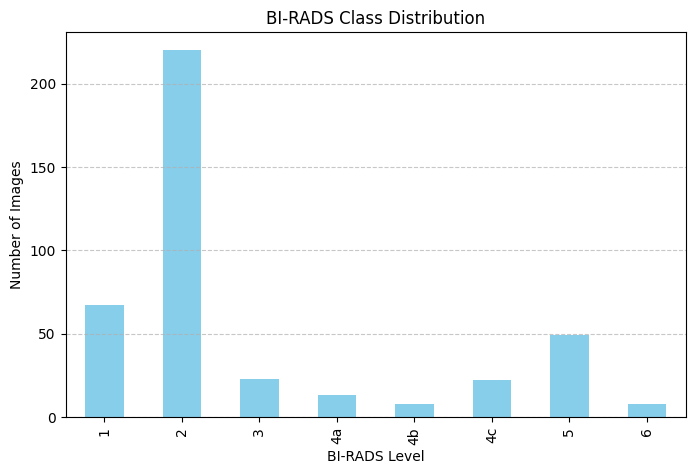

In [9]:
import matplotlib.pyplot as plt

# Count class distribution
birads_counts = df_clean["birads_label"].value_counts().sort_index()

# Visualize
plt.figure(figsize = (8, 5))
birads_counts.plot(kind = "bar", color = "skyblue")
plt.title("BI-RADS Class Distribution")
plt.xlabel("BI-RADS Level")
plt.ylabel("Number of Images")
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()

### 2.2.1. Sorting Images into Folders Based on BI-RADS Levels

* The .jpg files were copied into folders based on their classes using the df_clean DataFrame.

* Folder names were given as: "BI-RADS-1", "BI-RADS-2", "BI-RADS-3", "BI-RADS-4a", "BI-RADS-4b", "BI-RADS-4ac", "BI-RADS-5", "BI-RADS-6".

In [292]:
import shutil
from tqdm import tqdm

img_source_dir = "/content/JPGs"
output_dir = "/content/BI-RADS_split"
os.makedirs(output_dir, exist_ok=True)

for _, row in tqdm(df_clean.iterrows(), total=len(df_clean), desc = "Organizing images"):
    label = str(row["birads_label"]).strip()
    src = os.path.join(img_source_dir, row["filename"])
    dst_dir = os.path.join(output_dir, f"BIRADS_{label}")
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, row["filename"])

    if os.path.exists(src):
        shutil.copy(src, dst)

Organizing images: 100%|██████████| 410/410 [00:00<00:00, 830.08it/s]


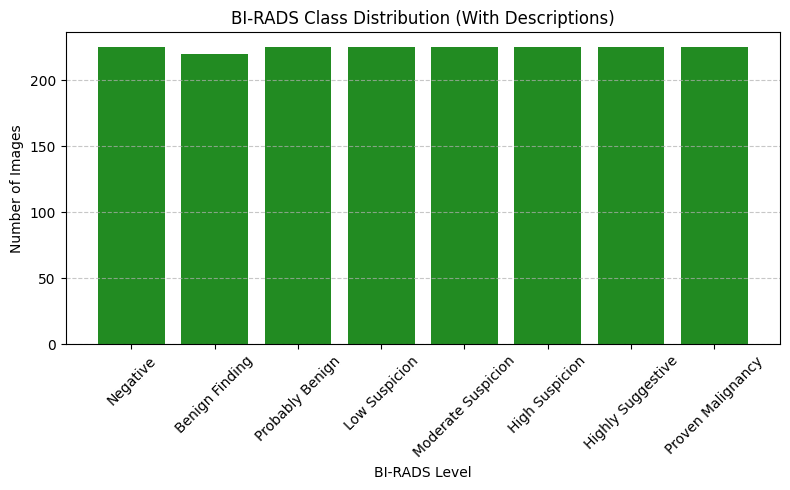

In [291]:
import matplotlib.pyplot as plt

# Label descriptions
label_map = {
    "1": "Negative",
    "2": "Benign Finding",
    "3": "Probably Benign",
    "4a": "Low Suspicion",
    "4b": "Moderate Suspicion",
    "4c": "High Suspicion",
    "5": "Highly Suggestive",
    "6": "Proven Malignancy"
}

def extract_label(folder_name):
    return folder_name.split("_")[-1].lower()

class_counts = {
    class_name: len([f for f in os.listdir(os.path.join(output_dir, class_name)) if f.endswith(".jpg")])
    for class_name in sorted(os.listdir(output_dir)) if class_name.startswith("BIRADS_")
}

sorted_labels = sorted(class_counts.keys(), key=lambda x: extract_label(x))

# Plot the chart
plt.figure(figsize=(8, 5))
plt.bar(
    [label_map.get(extract_label(l), extract_label(l)) for l in sorted_labels],
    [class_counts[l] for l in sorted_labels],
    color = "forestgreen"
)
plt.title("BI-RADS Class Distribution (With Descriptions)")
plt.xlabel("BI-RADS Level")
plt.ylabel("Number of Images")
plt.xticks(rotation = 45)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

## 2.3. Augmentation

Nested break statements were handled correctly.

The production count was controlled directly using a while loop.

Simplified using print instead of tqdm (can be added again if needed).

In [105]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

datagen = ImageDataGenerator(
    rotation_range = 2,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

target_count = 225
base_dir = output_dir  # /content/BI-RADS_split

for class_name in sorted(os.listdir(base_dir)):
    if class_name == "BIRADS_2":
        continue

    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
    to_generate = target_count - len(images)

    if to_generate <= 0:
        continue

    generated = 0
    while generated < to_generate:
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size = (224, 224))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for _ in datagen.flow(x, batch_size = 1,
                                  save_to_dir = class_path,
                                  save_prefix = "aug", save_format = "jpg"):
                generated += 1
                if generated >= to_generate:
                    break
            if generated >= to_generate:
                break

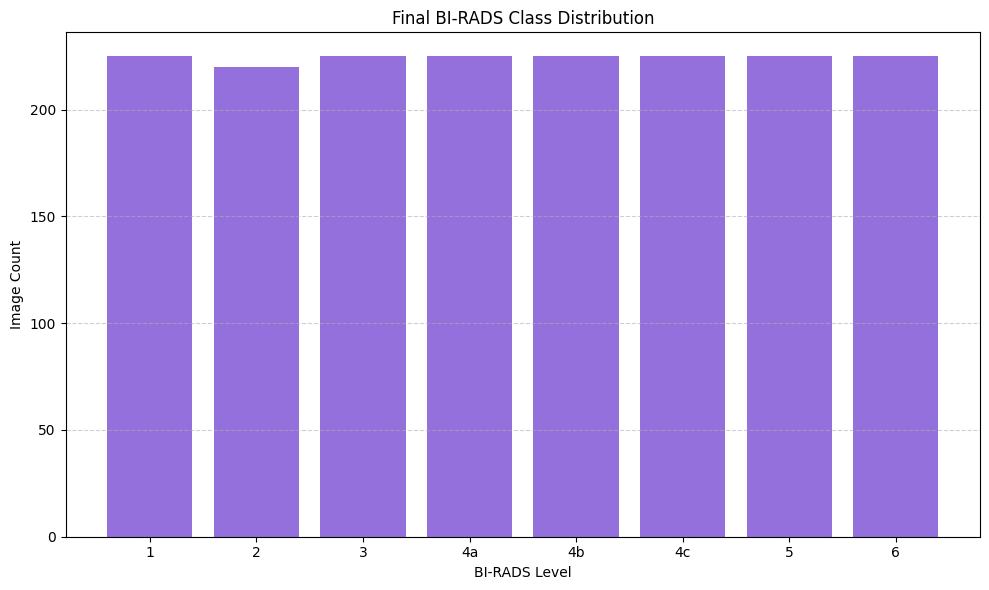

In [106]:
birads_counts_aug = {
    name: len([f for f in os.listdir(os.path.join(base_dir, name)) if f.endswith(".jpg")])
    for name in sorted(os.listdir(base_dir)) if name.startswith("BIRADS_")
}

x_labels = [extract_label(k) for k in birads_counts_aug.keys()]
y_counts = list(birads_counts_aug.values())

plt.figure(figsize=(10, 6))
plt.bar(x_labels, y_counts, color="mediumpurple")
plt.title("Final BI-RADS Class Distribution")
plt.xlabel("BI-RADS Level")
plt.ylabel("Image Count")
plt.grid(axis = "y", linestyle = "--", alpha = 0.6)
plt.tight_layout()
plt.show()

# **3. Dataset Splitting**

In [110]:
import os
import cv2
import numpy as np

original_dir = "/content/BI-RADS_split"

all_classes = sorted(os.listdir(original_dir))

label_map = {}
for idx, label in enumerate(all_classes):
    label_map[label] = idx

img_size = 224

X = []
y = []

for label in all_classes:
    class_path = os.path.join(original_dir, label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0
            X.append(img)
            y.append(label_map[label])


X = np.array(X, dtype=np.float32)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1795, 224, 224, 3)
y shape: (1795,)


## 3.1. Train-Test-Split

In [111]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1436, 224, 224, 3)
y_train shape: (1436,)


# **4. Custom CNN Model**

In [240]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

## 4.1. Model Architecture

In [241]:
img_size = 224
num_classes = 8

if y_train.ndim != 2:
    y_train = to_categorical(y_train, num_classes = num_classes)
if y_test.ndim != 2:
    y_test = to_categorical(y_test, num_classes = num_classes)

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_cnn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )

In [242]:
# EarlyStopping
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
)

In [243]:
# ModelCheckpoint
checkpoint = ModelCheckpoint(
    "best_model_cnn.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

## 4.2. Training

In [244]:
import time
start = time.time()

history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 50,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2124 - loss: 2.5935
Epoch 1: val_accuracy improved from -inf to 0.55432, saving model to best_model_cnn.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.2144 - loss: 2.5825 - val_accuracy: 0.5543 - val_loss: 1.4547
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5897 - loss: 1.2148
Epoch 2: val_accuracy improved from 0.55432 to 0.67967, saving model to best_model_cnn.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5902 - loss: 1.2138 - val_accuracy: 0.6797 - val_loss: 1.0083
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7620 - loss: 0.7880
Epoch 3: val_accuracy improved from 0.67967 to 0.74652, saving model to best_model_cnn.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.7616 - loss: 0.7879 - val_accuracy: 0.7465 - val_loss: 0.8846
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8434 - loss: 0.5045
Epoch 4: val_accuracy improved from

## 4.3. Evaluation

In [245]:
model_cnn.load_weights("best_model_cnn.keras")
loss, acc = model_cnn.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8082 - loss: 1.0099

 Test Accuracy: 0.7967 — Test Loss: 1.0533


## 4.4. Classification Report

In [289]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

           1       0.68      0.87      0.76        45
           2       0.50      0.43      0.46        44
           3       0.75      0.89      0.82        45
          4a       0.84      0.84      0.84        45
          4b       0.87      0.89      0.88        45
          4c       0.91      0.89      0.90        45
           5       0.85      0.64      0.73        45
           6       0.98      0.91      0.94        45

    accuracy                           0.80       359
   macro avg       0.80      0.80      0.79       359
weighted avg       0.80      0.80      0.79       359



## 4.5. Confusion Matrix

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model

model = load_model('/content/best_model_cnn.keras')

class_names = [
  "1", "2", " 3", "4a", "4b", "4c", "5", "6"
]

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis = 1)

if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis = 1)
else:
    y_true = y_test

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


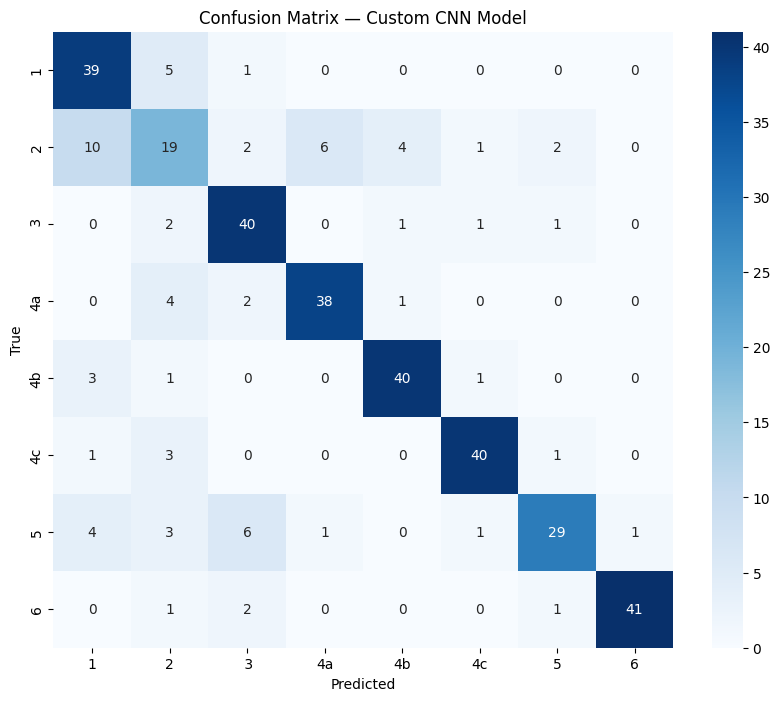

In [247]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix — Custom CNN Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 4.6. Accuracy & Loss Graphs

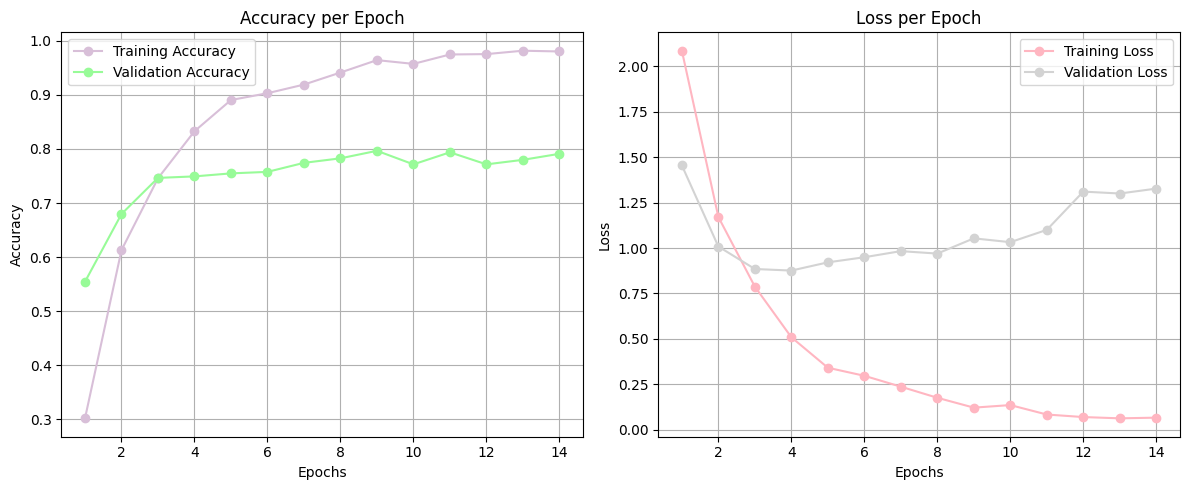

In [249]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker = 'o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 4.7. ROI Visualization

In [250]:
pip install roifile

In [251]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

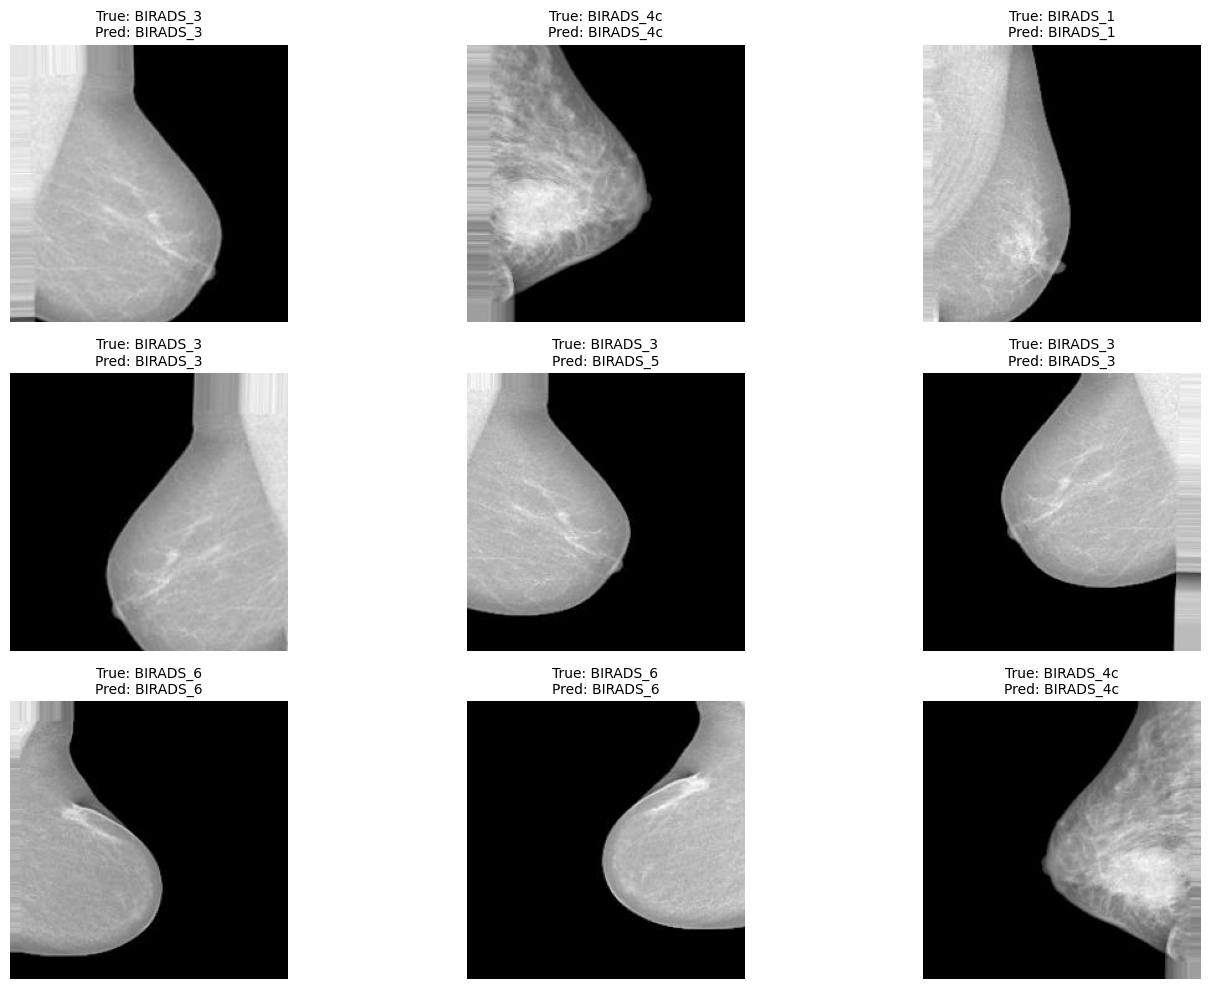

In [252]:
class_names = ["BIRADS_1", "BIRADS_2", "BIRADS_3", "BIRADS_4a", "BIRADS_4b", "BIRADS_4c", "BIRADS_5", "BIRADS_6"]

indices = random.sample(range(len(X_test)), 9)

plt.figure(figsize = (15, 10))

for i, idx in enumerate(indices):
    img_array = X_test[idx]
    true_label = class_names[np.argmax(y_test[idx])] if y_test.ndim == 2 else class_names[y_test[idx]]

    # Prediction
    input_img = np.expand_dims(img_array, axis = 0)
    pred_idx = np.argmax(model_cnn.predict(input_img, verbose = 0))
    pred_label = class_names[pred_idx]

    # Visualization
    plt.subplot(3, 3, i + 1)
    plt.imshow(img_array)
    plt.axis("off")
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize = 10)

plt.tight_layout()
plt.show()

In [253]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Risk order of BI-RADS classes
birads_order = ['1', '2', '3', '4a', '4b', '4c', '5', '6']

# Normalization (values between 0 and 1)
birads_normalized = {label: i / (len(birads_order)-1) for i, label in enumerate(birads_order)}

# Color map: green to red (higher risk → more red)
cmap = cm.get_cmap('RdYlGn_r')  # reversed: 1 = green, 6 = red

# Get color based on class label
def get_color_from_birads(label):
    if label not in birads_normalized:
        return "gray"
    return mcolors.to_hex(cmap(birads_normalized[label]))

# Determine color based on prediction correctness
def get_roi_color_by_truth(true_label=None, pred_label=None):
    if true_label is None:
        return "mediumpurple"
    if pred_label != true_label:
        return "black"  # wrong prediction → black
    return get_color_from_birads(true_label)

# Generate color palette for each class
color_palette = {label: get_color_from_birads(label) for label in birads_order}
color_palette

{'1': '#006837',
 '2': '#39a758',
 '3': '#9dd569',
 '4a': '#e3f399',
 '4b': '#fee999',
 '4c': '#fca55d',
 '5': '#e34933',
 '6': '#a50026'}

In [254]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import os

# Function to calculate polygon area
def calculate_polygon_area(points):
    x = [p["x"] for p in points]
    y = [p["y"] for p in points]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    return area

# Draw ROI with approximate polygon area and color palette
def draw_roi_with_palette(img_path, image_id, annotations, true_label=None, pred_label=None, save_dir=None):
    from matplotlib.patches import Rectangle

    # Load image
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    # ROI data
    rois = annotations.get(image_id, [])
    total_area = 0

    # Create figure and axes: 1x2 grid (left: image, right: color palette)
    fig, (ax_img, ax_legend) = plt.subplots(1, 2, figsize = (12, 6), gridspec_kw = {'width_ratios': [3, 1]})
    ax_img.imshow(img_np)

    for roi in rois:
        points = roi["points"]
        if len(points) < 3:
            continue
        poly_coords = [(p["x"], p["y"]) for p in points]
        area = calculate_polygon_area(points)
        total_area += area

        color = get_roi_color_by_truth(true_label, pred_label)
        polygon = patches.Polygon(
            poly_coords,
            closed = True,
            edgecolor = color,
            facecolor = color,
            alpha = 0.3,
            linewidth = 2
        )
        ax_img.add_patch(polygon)

    # Title and display settings
    title = f"True: {true_label or 'Unknown'}  Predicted: {pred_label or 'Unknown'}\n"
    title += f"ROI Area: {int(total_area)} pixels²"
    ax_img.set_title(title, fontsize = 12)
    ax_img.axis("off")

    # Palette layout settings
    box_height = 0.6
    spacing = 0.15

    extra_items = 2  # Misestimation + Unknown
    total_items = len(birads_order) + extra_items
    full_height = total_items * (box_height + spacing)

    ax_legend.set_xlim(0, 1)
    ax_legend.set_ylim(0, full_height)
    ax_legend.axis("off")

    # Draw palette boxes
    for i, label in enumerate(birads_order):
        y = i * (box_height + spacing)
        color = get_color_from_birads(label)
        ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color=color))
        ax_legend.text(0.55, y + box_height / 2, f"BI-RADS {label}", va = 'center', ha = 'left', fontsize = 10)

    # Misestimation box (black)
    y = len(birads_order) * (box_height + spacing)
    ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color="black"))
    ax_legend.text(0.55, y + box_height / 2, "Misestimation", va = 'center', ha = 'left', fontsize = 10)

    # Unknown box (purple)
    y = (len(birads_order) + 1) * (box_height + spacing)
    ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color="mediumpurple"))
    ax_legend.text(0.55, y + box_height / 2, "Unknown", va = 'center', ha = 'left', fontsize = 10)

    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok = True)
        out_path = os.path.join(save_dir, image_id.replace(".jpg", "_with_palette.png"))
        plt.savefig(out_path)
        plt.close()
    else:
        plt.show()

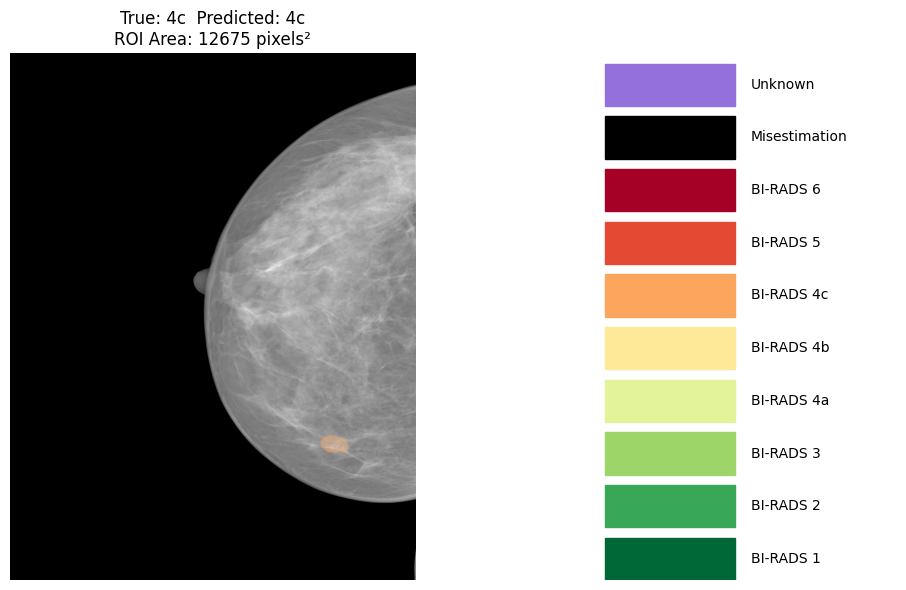

In [278]:
import random

# Filter images that contain ROIs with polygons having at least 3 points
valid_ids_with_polygon = [
    k for k, v in annotations.items()
    if any(len(roi["points"]) >= 3 for roi in v)
]

# Select a random sample
sample_id = random.choice(valid_ids_with_polygon)
img_path = f"/content/JPGs/{sample_id}"

# Randomly assign true and predicted labels (for testing purposes)
true_label = random.choice(birads_order)
pred_label = random.choice(birads_order)

# Draw the enhanced ROI visualization with color palette
draw_roi_with_palette(
    img_path = img_path,
    image_id = sample_id,
    annotations = annotations,
    true_label = true_label,
    pred_label = pred_label,
    save_dir = None
)

# **5. DenseNet121**

In [156]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 5.1. Model Architecture

In [279]:
input_shape = (224, 224, 3)
num_classes = 8

base_model = DenseNet121(weights = 'imagenet', include_top = False, input_tensor = Input(shape = input_shape))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

# Final model
model_densenet = Model(inputs = base_model.input, outputs = output)

# Compile
model_densenet.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_densenet.summary()

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_8    │ (None, 230, 230,  │          0 │ input_layer_18[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_8… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_9    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_9… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 13,461,192 (51.35 MB)

 Trainable params: 6,423,688 (24.50 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [280]:
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )

checkpoint = ModelCheckpoint(
    "best_model_densenet.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
    )

## 5.2. Training

In [281]:
import time
start = time.time()

history_densenet = model_densenet.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5199 - loss: 1.8763
Epoch 1: val_accuracy improved from -inf to 0.86351, saving model to best_model_densenet.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 625ms/step - accuracy: 0.5236 - loss: 1.8607 - val_accuracy: 0.8635 - val_loss: 0.4407
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8497 - loss: 0.5232
Epoch 2: val_accuracy improved from 0.86351 to 0.87744, saving model to best_model_densenet.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.8497 - loss: 0.5228 - val_accuracy: 0.8774 - val_loss: 0.4288
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8639 - loss: 0.4442
Epoch 3: val_accuracy did not improve from 0.87744
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.8640 - loss: 0.4438 - val_accuracy: 0.8691 - val_loss: 0.4128
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9008 - loss: 0.3228
Epoch 4: val_accuracy did not improve from 0.87744
45/45 ━━━

## 5.3. Evaluation

In [282]:
from tensorflow.keras.models import load_model

model = load_model("best_model_densenet.keras")

loss, acc = model.evaluate(X_test, y_test, verbose = 1)
print(f"\nTest Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 556ms/step - accuracy: 0.8732 - loss: 0.4555

Test Accuracy: 0.8886 — Test Loss: 0.4255


## 5.4. Cassification Report

In [283]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model

model = load_model('/content/best_model_cnn.keras')

class_names = [
  "1", "2", " 3", "4a", "4b", "4c", "5", "6"
]

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis = 1)

if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis = 1)
else:
    y_true = y_test

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [288]:
print(classification_report(y_true, y_pred, target_names = class_names))

              precision    recall  f1-score   support

           1       0.68      0.87      0.76        45
           2       0.50      0.43      0.46        44
           3       0.75      0.89      0.82        45
          4a       0.84      0.84      0.84        45
          4b       0.87      0.89      0.88        45
          4c       0.91      0.89      0.90        45
           5       0.85      0.64      0.73        45
           6       0.98      0.91      0.94        45

    accuracy                           0.80       359
   macro avg       0.80      0.80      0.79       359
weighted avg       0.80      0.80      0.79       359



## 5.5. Confusion Matrix

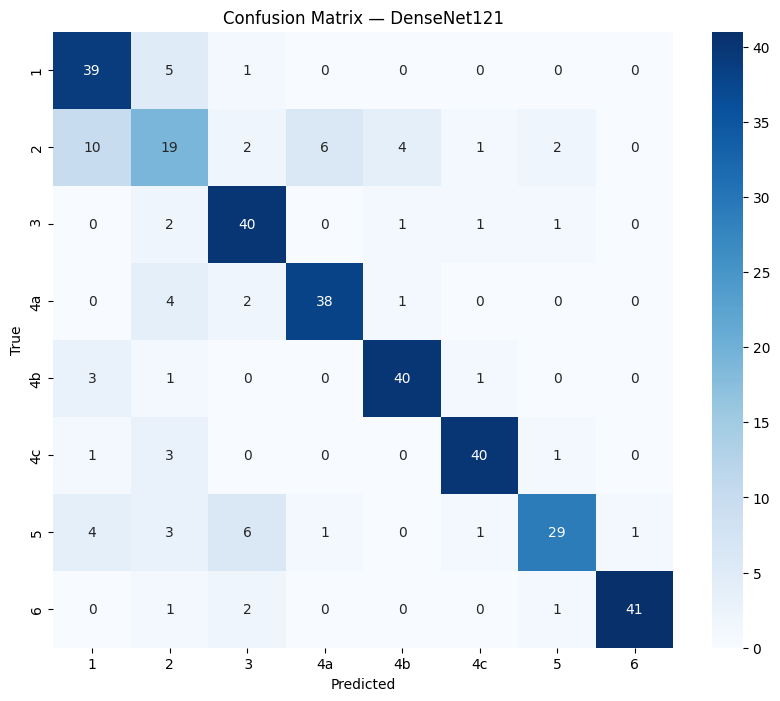

In [287]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix — DenseNet121")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 5.6. Accuracy & Loss Graphs

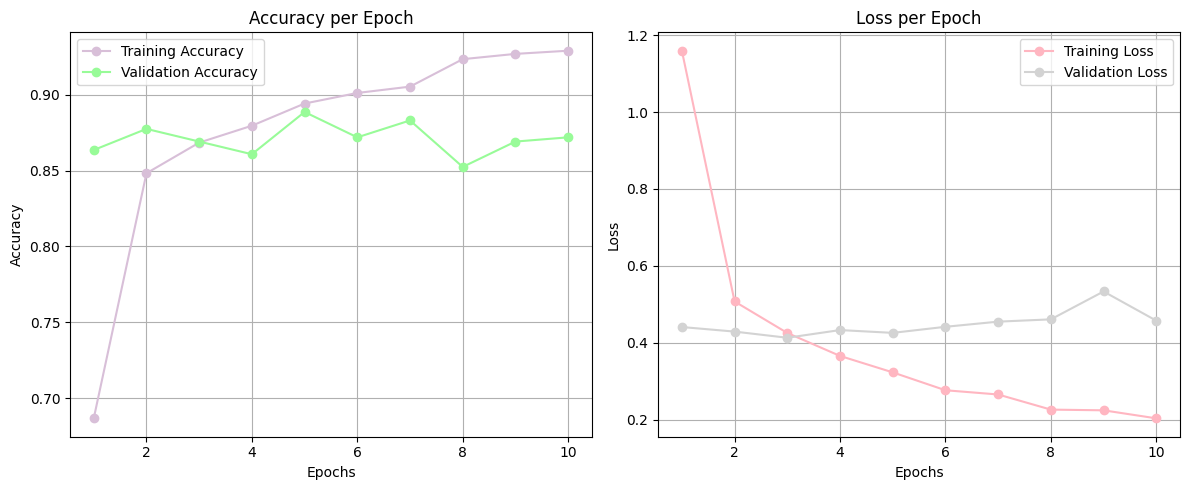

In [286]:
import matplotlib.pyplot as plt

acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']
loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **7. VGG16**

## 7.1. Feature Extraction

In [170]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

input_shape = (224, 224, 3)
num_classes = 8

base_model = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape = input_shape))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

# Final model
model_vgg16 = Model(inputs = base_model.input, outputs = output)

# Compile
model_vgg16.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_vgg16.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,927,112 (68.39 MB)

 Trainable params: 3,212,424 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 7.2. Training

In [171]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

checkpoint = ModelCheckpoint(
    "best_model_vgg16.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

In [172]:
import time
start = time.time()

history_vgg16 = model_vgg16.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2835']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.3602 - loss: 1.8366
Epoch 1: val_accuracy improved from -inf to 0.83565, saving model to best_model_vgg16.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 658ms/step - accuracy: 0.3643 - loss: 1.8278 - val_accuracy: 0.8357 - val_loss: 0.8067
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7794 - loss: 0.8067
Epoch 2: val_accuracy improved from 0.83565 to 0.85515, saving model to best_model_vgg16.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.7796 - loss: 0.8062 - val_accuracy: 0.8552 - val_loss: 0.5952
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8220 - loss: 0.6883
Epoch 3: val_accuracy did not improve from 0.85515
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.8222 - loss: 0.6874 - val_accuracy: 0.8301 - val_loss: 0.5401
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8427 - loss: 0.5694
Epoch 4: val_accuracy improved from 0.85515 to 0.86908, saving model to 

## 7.3. Evaluation

In [173]:
from tensorflow.keras.models import load_model

best_model_vgg16 = load_model("best_model_vgg16.keras")
loss, acc = model_vgg16.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.8695 - loss: 0.4491

 Test Accuracy: 0.8802 — Test Loss: 0.4404


## 7.4. Cassification Report

In [177]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred_probs = best_model_vgg16.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names = class_names))

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step
              precision    recall  f1-score   support

           1       0.82      0.71      0.76        45
           2       0.59      0.84      0.69        44
           3       0.98      0.96      0.97        45
          4a       0.98      0.93      0.95        45
          4b       1.00      0.93      0.97        45
          4c       0.95      0.91      0.93        45
           5       0.88      0.78      0.82        45
           6       0.98      0.98      0.98        45

    accuracy                           0.88       359
   macro avg       0.90      0.88      0.88       359
weighted avg       0.90      0.88      0.88       359



## 7.5. Confusion Matrix

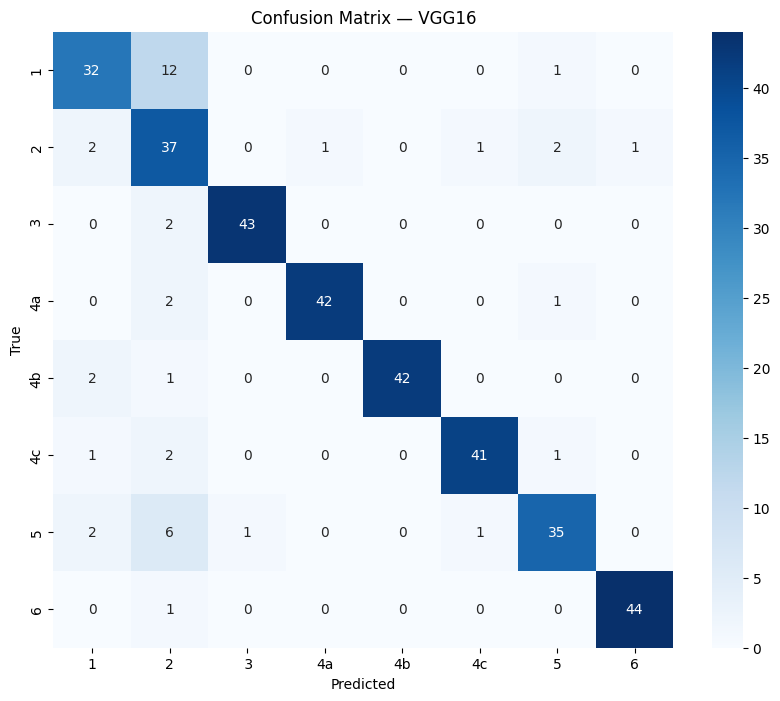

In [180]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix — VGG16")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 7.6. Accuracy & Loss Graphs

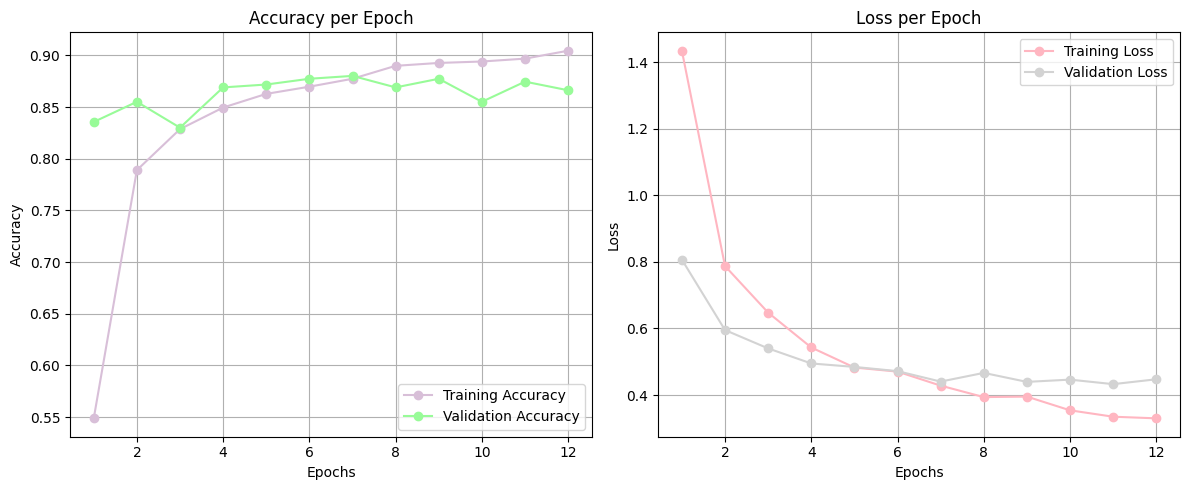

In [181]:
import matplotlib.pyplot as plt

acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **8. EfficientNetB0**

In [211]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## 8.1. Feature Extraction

In [213]:
input_shape = (224, 224, 3)
num_classes = 8

base_model = EfficientNetB0(weights = 'imagenet', include_top = False, input_tensor = Input(shape = input_shape))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

# Final model
model_efficientnet = Model(inputs = base_model.input, outputs = output)

In [214]:
# Compile
model_efficientnet.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_efficientnet.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_14[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,571 (16.08 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [215]:
# Callbacks
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )
checkpoint = ModelCheckpoint(
    "best_model_efficientnet.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
    )

## 8.2. Training

In [216]:
import time
start = time.time()

history_efficient = model_efficientnet.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3890']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.1223 - loss: 2.1335
Epoch 1: val_accuracy improved from -inf to 0.12535, saving model to best_model_efficientnet.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 460ms/step - accuracy: 0.1222 - loss: 2.1329 - val_accuracy: 0.1253 - val_loss: 2.0802
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1160 - loss: 2.1030
Epoch 2: val_accuracy did not improve from 0.12535
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.1158 - loss: 2.1030 - val_accuracy: 0.1253 - val_loss: 2.0798
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1137 - loss: 2.0895
Epoch 3: val_accuracy did not improve from 0.12535
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.1136 - loss: 2.0895 - val_accuracy: 0.1253 - val_loss: 2.0796
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1006 - loss: 2.0878
Epoch 4: val_accuracy did not improve from 0.12535
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.1008 - loss

## 8.3. Evaluation

In [218]:
from tensorflow.keras.models import load_model

best_model_efficientnet = load_model("best_model_efficientnet.keras")
loss, acc = model_efficientnet.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1158 - loss: 2.0777

 Test Accuracy: 0.1253 — Test Loss: 2.0802


In [219]:
# Prediction
y_pred_probs = model_efficientnet.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 523ms/step


## 8.4. Cassification Report

In [234]:
print(classification_report(y_true, y_pred, target_names = class_names))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        45
           2       0.00      0.00      0.00        44
           3       0.13      1.00      0.22        45
          4a       0.00      0.00      0.00        45
          4b       0.00      0.00      0.00        45
          4c       0.00      0.00      0.00        45
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00        45

    accuracy                           0.13       359
   macro avg       0.02      0.12      0.03       359
weighted avg       0.02      0.13      0.03       359



## 8.5. Confusion Matrix

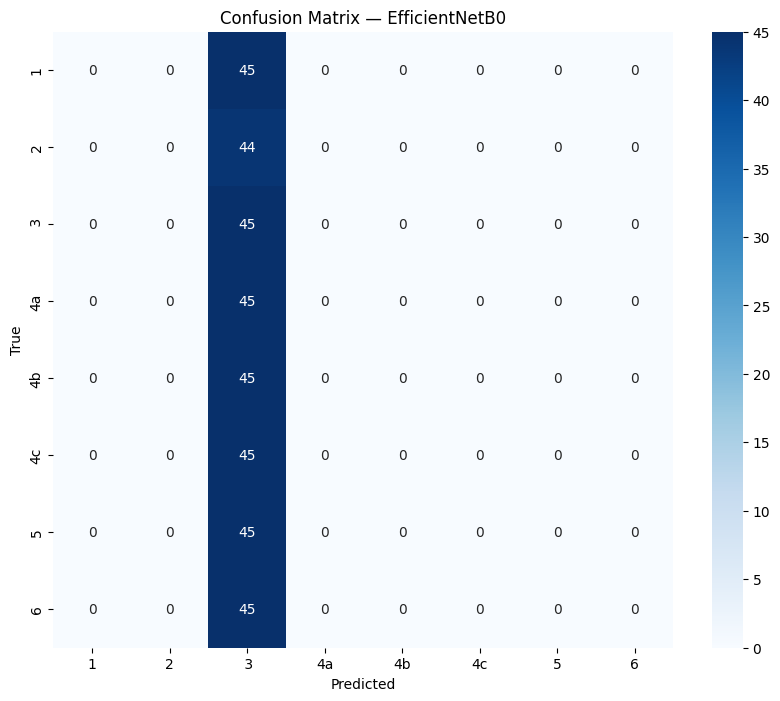

In [236]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — EfficientNetB0')
plt.show()

## 8.6. Accuracy & Loss Graphs

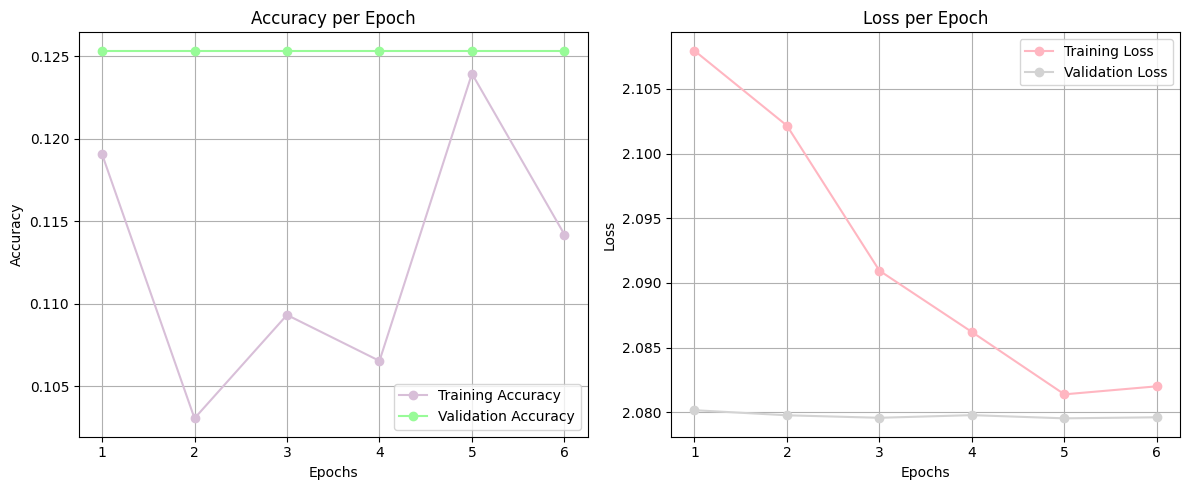

In [238]:
import matplotlib.pyplot as plt

acc = history_efficient.history['accuracy']
val_acc = history_efficient.history['val_accuracy']
loss = history_efficient.history['loss']
val_loss = history_efficient.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **9. ResNet50**

In [223]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 9.1. Feature Extraction

In [226]:
input_shape = (224, 224, 3)
num_classes = 8

base_model = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = input_shape))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

model_resnet50 = Model(inputs = base_model.input, outputs = output)

# Compile
model_resnet50.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_resnet50.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_16[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,016 (90.98 MB)

 Trainable params: 263,304 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [231]:
# Callbacks
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )
checkpoint = ModelCheckpoint(
    "best_model_resnet50.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
    )

## 9.2. Training

In [232]:
import time
start = time.time()

history_resnet50 = model_resnet50.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2494 - loss: 2.0294
Epoch 1: val_accuracy improved from -inf to 0.30362, saving model to best_model_resnet50.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.2497 - loss: 2.0293 - val_accuracy: 0.3036 - val_loss: 2.0197
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2523 - loss: 2.0249
Epoch 2: val_accuracy improved from 0.30362 to 0.47632, saving model to best_model_resnet50.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.2523 - loss: 2.0248 - val_accuracy: 0.4763 - val_loss: 2.0116
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2672 - loss: 2.0178
Epoch 3: val_accuracy improved from 0.47632 to 0.54875, saving model to best_model_resnet50.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.2673 - loss: 2.0178 - val_accuracy: 0.5487 - val_loss: 2.0057
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3035 - loss: 2.0099
Epoch 4: val_a

## 9.3. Evaluation

In [233]:
from tensorflow.keras.models import load_model

best_model_resnet50 = load_model("best_model_resnet50.keras")
loss, acc = model_resnet50.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5612 - loss: 2.0099

 Test Accuracy: 0.5487 — Test Loss: 2.0057


## 9.4. Cassification Report

In [235]:
print(classification_report(y_true, y_pred, target_names = class_names))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        45
           2       0.00      0.00      0.00        44
           3       0.13      1.00      0.22        45
          4a       0.00      0.00      0.00        45
          4b       0.00      0.00      0.00        45
          4c       0.00      0.00      0.00        45
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00        45

    accuracy                           0.13       359
   macro avg       0.02      0.12      0.03       359
weighted avg       0.02      0.13      0.03       359



## 9.5. Confusion Matrix

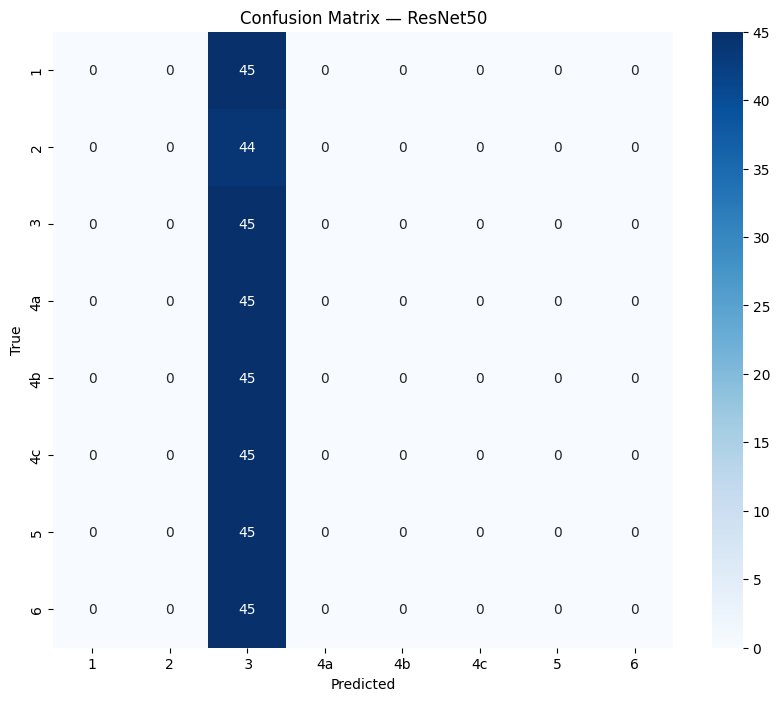

In [237]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — ResNet50')
plt.show()

## 9.6. Accuracy & Loss Graphs

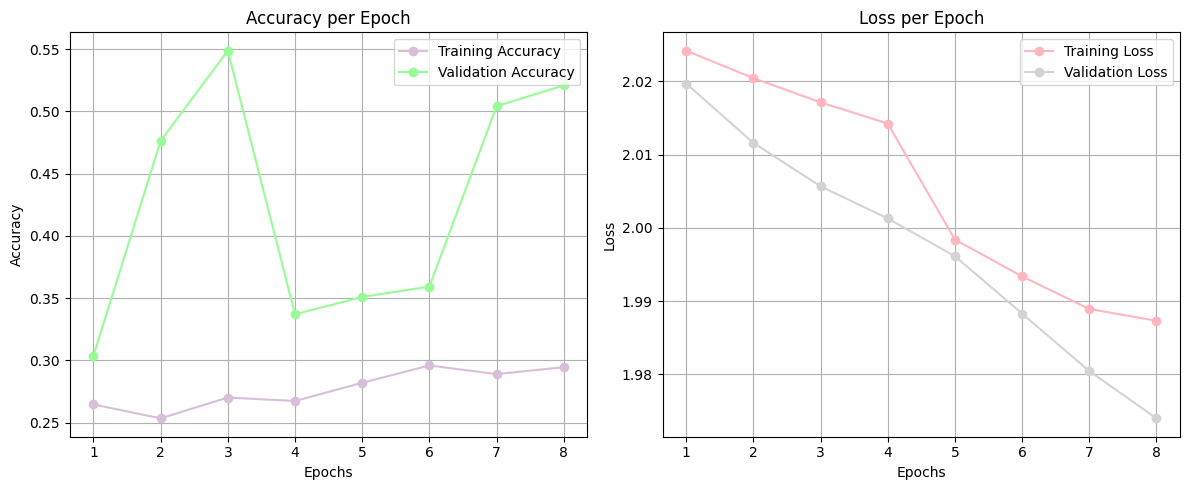

In [239]:
import matplotlib.pyplot as plt

acc = history_resnet50.history['accuracy']
val_acc = history_resnet50.history['val_accuracy']
loss = history_resnet50.history['loss']
val_loss = history_resnet50.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()